 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8889/notebooks/13-bboxes-revisit.ipynb#Load-libraries" data-toc-modified-id="Load-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries</a></span></li><li><span><a href="http://localhost:8889/notebooks/13-bboxes-revisit.ipynb#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="http://localhost:8889/notebooks/13-bboxes-revisit.ipynb#Dimensions-of-actual-masks" data-toc-modified-id="Dimensions-of-actual-masks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dimensions of actual masks</a></span></li><li><span><a href="http://localhost:8889/notebooks/13-bboxes-revisit.ipynb#Load-previously-trained-model" data-toc-modified-id="Load-previously-trained-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load previously trained model</a></span></li><li><span><a href="http://localhost:8889/notebooks/13-bboxes-revisit.ipynb#Generate-predictions" data-toc-modified-id="Generate-predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Generate predictions</a></span></li><li><span><a href="http://localhost:8889/notebooks/13-bboxes-revisit.ipynb#bounding-boxes" data-toc-modified-id="bounding-boxes-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>bounding boxes</a></span></li></ul></div>

# Load libraries

In [1]:
import cv2
import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
import keras.backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from os import listdir
ids_list = [x.split('.')[0] for x in listdir('data/train')]

# Functions

In [4]:
def find_bounding_boxes(tmp):
    
    axis_0_sum = np.sum(tmp, axis=0)
    axis_1_sum = np.sum(tmp, axis=1)np.sum(tmp, axis=1)
    
    y_min = np.nonzero(axis_1_sum)[0][0]
    y_max = np.nonzero(axis_1_sum)[0][-1]
    
    x_min = np.nonzero(axis_0_sum)[0][0]
    x_max = np.nonzero(axis_0_sum)[0][-1]
    
    return (x_min, x_max, y_min, y_max)

In [5]:
def fbbi(i):
    tmp = np.copy(preds[i,:,:])
    return find_bounding_boxes(tmp)

In [6]:
def plot_bounding_box(i):
    (x_min, x_max, y_min, y_max) = fbbi(i)
    tmp = np.copy(preds[i,:,:])
    tmp[y_min,:] = -1
    tmp[y_max,:] = -1
    tmp[:,x_min] = -1
    tmp[:,x_max] = -1
    plt.figure(figsize=(10, 10))
    plt.imshow(tmp);

In [7]:
import bcolz

In [8]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()


def load_array(fname):
    return bcolz.open(fname)[:]

# Dimensions of actual masks

In [9]:
mask_bboxes={}
for id in ids_list:
    mask = cv2.imread('data/train_masks/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)/255
    mask_bboxes[id] = find_bounding_boxes(mask)

In [10]:
df = pd.DataFrame.from_dict(mask_bboxes, 'index')

In [11]:
df.columns=['xmin', 'xmax', 'ymin', 'ymax']

In [12]:
df['id'] = df.index

In [13]:
import re
angle_data = [re.search(r'[0-9]+$', x).group(0) for x in df.id.values]
df = df.assign(angle = angle_data)

In [14]:
df['xsize'] = df.xmax-df.xmin
df['ysize'] = df.ymax-df.ymin

In [15]:
df.head()

,xmin,xmax,ymin,ymax,id,angle,xsize,ysize
fecea3036c59_13,28,1649,346,998,fecea3036c59_13,13,1621,652
a078586ccdee_10,338,1279,497,1096,a078586ccdee_10,10,941,599
a2df64508b97_06,245,1594,290,851,a2df64508b97_06,06,1349,561
4bea0766c14c_10,326,1292,390,1023,4bea0766c14c_10,10,966,633
c3614abc7405_09,595,1345,360,1016,c3614abc7405_09,09,750,656


In [16]:
# Max widths and heights by angle
max_sizes = df.groupby('angle')['xsize', 'ysize'].max().reset_index()
max_sizes

,angle,xsize,ysize
0,01,1065,1005
1,02,1351,1002
2,03,1612,960
3,04,1862,860
4,05,1917,753
5,06,1864,791
6,07,1683,851
7,08,1452,863
8,09,1125,841
9,10,1370,875


# Load previously trained model

In [30]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_loss(y_true, y_pred))

def unet_down_one_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet_max_pool(inputs):
    x = MaxPooling2D((2, 2), strides=(2, 2))(inputs)
    return x

def unet_up_one_block(up_input, down_input, num_filters):
    x = UpSampling2D((2,2))(up_input)
    x = concatenate([down_input, x], axis=3)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def get_unet(input_shape = (256, 256, 3),
             num_classes = 1,
             initial_filters = 32,
             central_filters = 1024):
    
    num_filters = initial_filters
    
    out_list    = [Input(shape=input_shape)]
    down_interim_list = []
    
    while num_filters <= central_filters/2:
        x = unet_down_one_block(out_list[-1], num_filters)
        down_interim_list.append(x)
        num_filters = num_filters * 2
        y = unet_max_pool(x)
        out_list.append(y)
    
    x = unet_down_one_block(out_list[-1], num_filters)
    out_list.append(x)
    num_filters = int(num_filters / 2)
    
    while num_filters >= initial_filters:
        x = unet_up_one_block(out_list[-1], down_interim_list.pop(), num_filters)
        out_list.append(x)
        num_filters = int(num_filters / 2)
    
    classify = Conv2D(num_classes, (1,1), activation = 'sigmoid')(out_list[-1])
    
    model = Model(inputs=out_list[0], outputs=classify)
    
    model.compile(optimizer=RMSprop(lr=0.0001),
                  loss=bce_dice_loss,
                  metrics=[dice_loss])
    
    return model

model = get_unet(input_shape=(512,512,3), initial_filters=16)
model.load_weights(filepath='weights/best_weights_512_2.hdf5')

# Generate predictions

In [31]:
input_size=512
all_imgs=[]
for id in ids_list:
    img = cv2.imread('data/train/{}.jpg'.format(id))
    img = cv2.resize(img, (input_size, input_size))
    all_imgs.append(img)

In [32]:
preds = model.predict(np.array(all_imgs, np.float32)/255, batch_size=32)
preds = np.squeeze(preds, axis=3)

In [37]:
save_array('preds512.dat', preds)

In [38]:
orig_preds = np.copy(preds)

# bounding boxes

In [17]:
orig_preds = load_array('./preds512.dat')

In [18]:
preds = (np.copy(orig_preds) > 0.1).astype(int)

(111, 454, 142, 373)


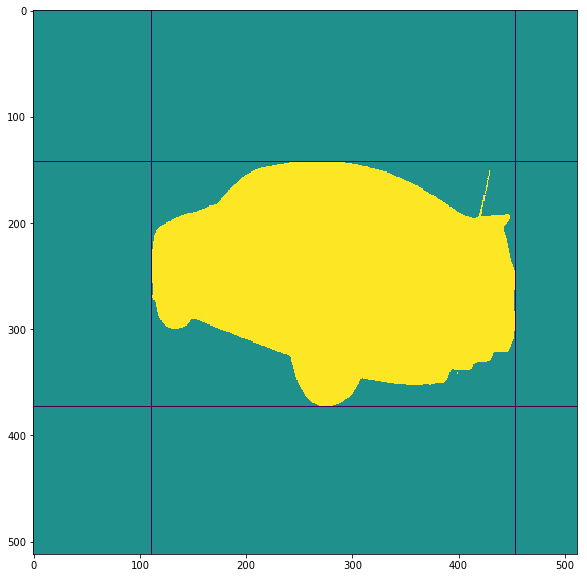

In [19]:
print(fbbi(10))
plot_bounding_box(10)

In [20]:
train_bboxes = {}
for i in range(len(ids_list)):
    train_bboxes[ids_list[i]] = fbbi(i)

In [47]:
train_bboxes_resized = {}
for id in train_bboxes:
    this_bbox = train_bboxes[id]
    train_bboxes_resized[id] = (
        this_bbox[0]*1918/512,
        this_bbox[1]*1918/512,
        this_bbox[2]*1280/512,
        this_bbox[3]*1280/512
    )

In [30]:
# Interested in only angle 9 values

In [136]:
train_bboxes_resized = { id: train_bboxes_resized[id] for id in df[df.angle=='09'].id.values }

In [137]:
x_min=[]
x_max=[]
y_min=[]
y_max=[]
for id in train_bboxes_resized:
    x_min.append(mask_bboxes[id][0] - train_bboxes_resized[id][0])
    x_max.append(train_bboxes_resized[id][1] - mask_bboxes[id][1])
    y_min.append(mask_bboxes[id][2] - train_bboxes_resized[id][2])
    y_max.append(train_bboxes_resized[id][3] - mask_bboxes[id][3])

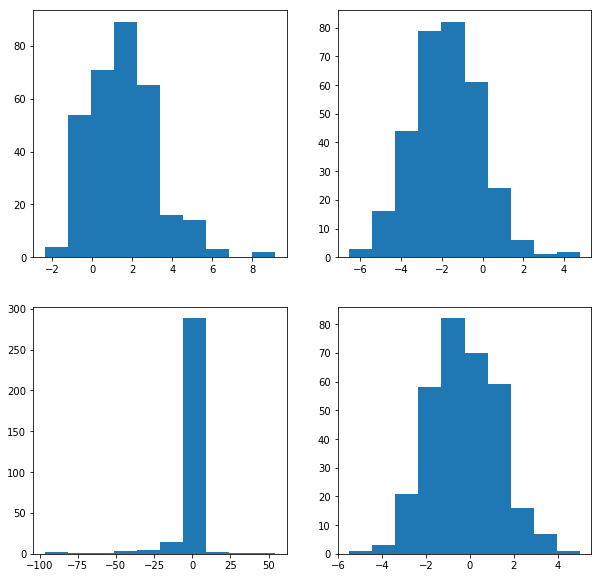

In [138]:
# There shoudn't be any points lesser than zero
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.hist(x_min)
plt.subplot(2,2,2)
plt.hist(x_max)
plt.subplot(2,2,3)
plt.hist(y_min)
plt.subplot(2,2,4)
plt.hist(y_max)
plt.show();

In [140]:
# bad points in ymin is mainly due to antennas

In [142]:
import pickle
pickle.dump( train_bboxes_resized, open( "train_bboxes_resized_m512_ang_09.pkl", "wb" ) )